In [2]:
# init
import findspark
findspark.init()

In [3]:
# Import lib
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StandardScaler
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
# Spark session
spark = SparkSession.builder.appName("Amazon Fine Food Reviews Classification").getOrCreate()

df = spark.read.csv('Reviews.csv', header=True, inferSchema=True)

In [14]:
df.show(100)

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|label|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|    1|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|    0|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|    1|
|  4|B000UA0QIQ|A395BORC6FGV

In [12]:
df_filtered = df.filter(df['Score'].between(1, 5))
score_counts_filtered = df_filtered.groupBy('Score').count()
score_counts_filtered.show()


+-----+------+
|Score| count|
+-----+------+
|    3| 42502|
|    5|361648|
|    1| 52635|
|    4| 80141|
|    2| 29877|
+-----+------+



In [15]:
df_filtered = df.filter(df['Score'].between(1, 5))
df_filtered.show()


+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|label|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+-----+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|    1|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|    0|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|    1|
|  4|B000UA0QIQ|A395BORC6FGV

In [16]:
# Drop missing value
df = df.dropna()

# Filter data untuk hanya menyertakan nilai Score antara 1 hingga 5
df = df.filter(df['Score'].between(1, 5))

# Labeling: Score > 3 dianggap sebagai positif (label = 1), lainnya negatif (label = 0)
df = df.withColumn("label", (df.Score > 3).cast("integer"))  # 1 positif, 0 negatif

# Split data menjadi training dan test set
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Proses tokenisasi, pembersihan stopwords, dan ekstraksi fitur
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# SVM classifier
svm = LinearSVC(maxIter=10, regParam=0.1, featuresCol="scaledFeatures", labelCol="label")
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, scaler, svm])
model = pipeline.fit(train_data)

# Prediksi menggunakan model pada data test
predictions = model.transform(test_data)

# Evaluasi model dengan metrik akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Menampilkan akurasi model
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8597108591790245


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12280\999488841.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")


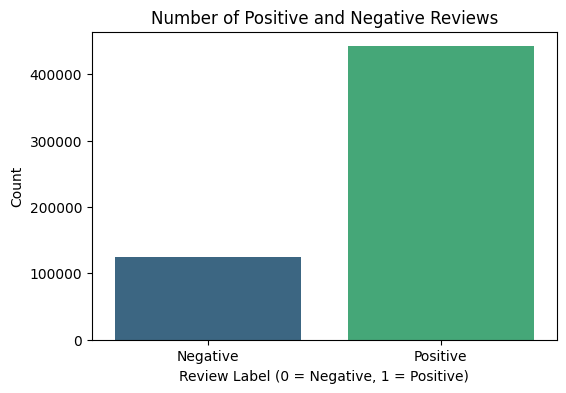

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_pandas = df.select('label').toPandas()
review_counts = df_pandas['label'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")
plt.title('Number of Positive and Negative Reviews')
plt.xlabel('Review Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()
